**Transformer-Based Language Model Built from Scratch**
--

# Data Preparation and Sampling


## Tokenizing

Dataset Used : 'Harry Potter Books'

In [1]:
pip install torch


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub
import os # Import the os module

# Download latest version
path = kagglehub.dataset_download("shubhammaindola/harry-potter-books")

print("Path to dataset files:", path)

# Find the text file within the downloaded directory

text_file_path = None
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        text_file_path = os.path.join(path, filename)
        break

if text_file_path:
    with open(text_file_path, 'r', encoding="utf-8") as f:
        raw_text = f.read()
    print("Successfully read the text file.")
else:
    print("Could not find a .txt file in the downloaded directory.")

/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Path to dataset files: /Users/tejas/.cache/kagglehub/datasets/shubhammaindola/harry-potter-books/versions/1
Successfully read the text file.


In [4]:
print("length of dataset in characters: ", len(raw_text))

length of dataset in characters:  1140011


Now we proceed with tokenizing all the words

using 're' library

In [5]:
import re

split individual words by (whitespaces , commas , fullstops)

Removing whitespaces is optional and has its pros and cons

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)',raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:20])

['The', 'two', 'men', 'appeared', 'out', 'of', 'nowhere', ',', 'a', 'few', 'yards', 'apart', 'in', 'the', 'narrow', ',', 'moonlit', 'lane', '.', 'For']


In [7]:
print(len(preprocessed))

243775


### Word based Tokenizer

convert to token IDs

1. Create vocabulary


In [8]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)


14357


In [9]:
vocab = {token : integer for integer, token in enumerate(all_words)}

In [10]:
for i , item in enumerate(vocab.items()):
    print(item)
    if i == 10:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
('*', 5)
('*Reducio*“', 6)
('*name*', 7)
(',', 8)
('-', 9)
('--', 10)


TOKENIZE CLASS

In [11]:
class SimpleTokenizerV1:
  def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {integer: token for token, integer in vocab.items()}

  def encode(self, text):
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)',text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    ids = [self.str_to_int[token] for token in preprocessed]
    return ids

  def decode(self, ids):
    tokens = [self.int_to_str[id] for id in ids]
    text = " ".join(tokens)
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) # to get rid of spaces before punctuations
    return text

In [12]:
tokenizer = SimpleTokenizerV1(vocab)

text = """I am Harry"""

ids = tokenizer.encode(text)

print(ids)

[1024, 2494, 927]


In [13]:
text = tokenizer.decode(ids)
print(text)

I am Harry


Thus Encode and Decode is working , but what if the word isn't present in the vocab ?

#### Special Contet Tokens

for words not in vocabulary-|unk| and markers - |endoftext|
1. |unk| -> 9461
2. |endoftext| -> 9462

In [14]:
all_tokens = sorted(set(preprocessed))
all_tokens.extend(["<unk>","<endoftext>"])
vocab = {token : integer for integer, token in enumerate(all_tokens)}
len(vocab.items())

14359

In [15]:
class SimpleTokenizerV2:
  def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {integer: token for token, integer in vocab.items()}

  def encode(self, text):
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)',text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    preprocessed = [

                    item if item in self.str_to_int else "<|unk|>" for item in preprocessed
    ]
    ids = [self.str_to_int[token] for token in preprocessed]
    return ids

  def decode(self, ids):
    tokens = [self.int_to_str[id] for id in ids]
    text = " ".join(tokens)
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) # to get rid of spaces before punctuations
    return text

### Byte Pair Encoding ( BPE )

* subword based tokenizer : split the rare words into easier subwords
* Most common pair of continuous byte pair ( left to right ) , with byte that doesn't occur in the data ( Repeat )
* aaabdaaabac -> aa ab d aa ab ac -> Z Y d Z Y ac -> ZY d ZY ac -> WdWac
* Similar algo is used for tokenization in LLMs , we just merge byte pairs by making frequency table of charecters of the whole dataset.
* Subtract the numberof frequency from the original charecter after we merge it with another charecter
* remove the tokens with 0 frequency
* stopping criteria must be specified ( based on iterations or number of tokens )


LIBRARY USED : TIKTOKEN

In [16]:
! pip3 install tiktoken


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
import importlib
import tiktoken

importlib.metadata.version('tiktoken')

'0.9.0'

In [18]:
tokenizer = tiktoken.get_encoding('gpt2')

In [19]:
text = ("Hello , do you really like mushrooms ? <|endoftext|> In the moonlit terraces of 'unknown' palaaacesssss")

integers = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
print(integers)

[15496, 837, 466, 345, 1107, 588, 23452, 5633, 220, 50256, 554, 262, 8824, 18250, 8812, 2114, 286, 705, 34680, 6, 279, 6081, 64, 330, 408, 824, 82]


In [20]:
strings = tokenizer.decode(integers)
strings

"Hello , do you really like mushrooms ? <|endoftext|> In the moonlit terraces of 'unknown' palaaacesssss"

GPT2 encoder has 50256 tokens

### Creating Input - Target pairs

LLMs are - Autoregressive , Self-supervised

create input output pairs using sliding window approach

In [21]:
enc_text = tokenizer.encode(raw_text)

len(enc_text)

305068

In [22]:
enc_sample = enc_text[:100]

create 2 variables x , y ; where y is x shifted by 1 token.

Therefore if x is the input , y should be the output.

**context_size** : the number of tokens the model needs to focus on, inorder to predict the new word


example : x = [1,2,3,4] , y = [2,3,4,5] , context_size = 4

In [23]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(x , y)

[464, 734, 1450, 4120] [734, 1450, 4120, 503]


Number of prediction in one input output pair depends on context_size

for 4 , it is 4 predictions as below

In [24]:
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), " -----> ", tokenizer.decode([desired]))

The  ----->   two
The two  ----->   men
The two men  ----->   appeared
The two men appeared  ----->   out


#### Data Loader

using Pytorch's inbuilt Dataset & Dataloader classes

step 1 : Tokenizing entire dataset

step 2 : Create dataset


In [25]:
import torch

In [26]:
from torch.utils.data import Dataset , DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"}) # tokenize

    # Using sliding window of max length
    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]




helps us in paralell processing

In [27]:
def create_dataloader_v1(txt , batch_size = 4 , max_length = 256 , stride = 128 , shuffle = True , drop_last = True , num_workers = 0):

  # initialize the tokenizer
  tokenizer = tiktoken.get_encoding('gpt2')

  dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)

  dataloader = DataLoader(dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          drop_last=drop_last,
                          num_workers=num_workers)

  return dataloader

Test : batch size = 1 , context size = 4

In [28]:
dataloader = create_dataloader_v1(raw_text,batch_size=1,max_length=4,stride=1,shuffle = False)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[ 464,  734, 1450, 4120]]), tensor([[ 734, 1450, 4120,  503]])]


In [29]:
dataloader = create_dataloader_v1(raw_text,batch_size=8,max_length=4,stride=4,shuffle = False)

data_iter = iter(dataloader)
inputs , targets = next(data_iter)

print('Inputs:\n' , inputs)
print('Targets:\n' , targets)

Inputs:
 tensor([[  464,   734,  1450,  4120],
        [  503,   286, 12062,    11],
        [  257,  1178,  5695,  5475],
        [  287,   262,  7135,    11],
        [ 8824, 18250, 11193,    13],
        [ 1114,   257,  1218,   484],
        [ 6204,  2407,   991,    11],
        [  266,  1746,  7924,   379]])
Targets:
 tensor([[  734,  1450,  4120,   503],
        [  286, 12062,    11,   257],
        [ 1178,  5695,  5475,   287],
        [  262,  7135,    11,  8824],
        [18250, 11193,    13,  1114],
        [  257,  1218,   484,  6204],
        [ 2407,   991,    11,   266],
        [ 1746,  7924,   379,  1123]])


Less stride -> More overlap -> More OverFitting

stride length = max length => no overlap and also no token miss

## Token Embeddings

* Every Token is represented by an N dimensional Vector
* Captures Semantic relationship between words --> Unrelated words are farther from each other
* Train an NN to create such Embeddings

Examples : word2vec-google-news-300 ( pretrained - 300 dimensional )

---

For GPT-2 : vocab size : 50257 , embedding dimension - 768

Therefore Embedding Layer Weight matrix size is  50257*768

These weights are initialized randomly and optimized using LLM training itself (torch.nn.embedding)

---

**Positional Encoding**


2 types :

1. Absolute : a unique embedding is added to the token embedding so that the embeddings become different if the same word appears in different positions. (GPT was trained with this)

2. Relative : emphasis on distance between the words , it can generalize better to sequence of long lengths.

In [30]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size,output_dim)

In [31]:
max_length = 4
Dataloader = create_dataloader_v1(raw_text , batch_size = 8 , max_length=max_length , stride = max_length , shuffle = False)
data_iter = iter(Dataloader)

inputs , targets = next(data_iter)

one embedding of 256 dimension is generated for each of the input

In [32]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


Create embedding for positional encoding ( only 4 position here => 4*256 )

In [33]:
context_length = max_length

pos_embedding_layer = torch.nn.Embedding(context_length,output_dim)

pos_embedding_layer = pos_embedding_layer(torch.arange(max_length))

print(pos_embedding_layer.shape)

torch.Size([4, 256])


Add : Token Embeddings + Positional Embeddings

In [34]:
final_embeddings = token_embeddings + pos_embedding_layer
print(final_embeddings.shape)

torch.Size([8, 4, 256])


# Transformer Architecture

## Attention

-> Simple attention - No trainable weights ; K=Q=V = X


### Self attention - Trainable weights ; K = Wk@X , Q = Wq@X , V = Wv@X

In [35]:
import torch.nn as nn
import torch

# SELF ATTENTION V1
class SelfAttention_v1(nn.Module):

  def __init__(self,d_in,d_out): # d_in = input dimension
    super().__init__()
    self.W_q = nn.Parameter(torch.rand(d_in,d_out))
    self.W_k = nn.Parameter(torch.rand(d_in,d_out))
    self.W_v = nn.Parameter(torch.rand(d_in,d_out))

  def forward(self,x):
    keys = x @ self.W_k
    query = x @ self.W_q
    value = x @ self.W_v

    attention_weights = torch.softmax((query @ keys.T)/(keys.shape[-1])**0.5 , dim = -1)

    context_vec = attention_weights @ value
    return context_vec

In [36]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(3,2)
print(sa_v1(torch.rand(6,3)))

tensor([[0.3558, 0.9283],
        [0.3565, 0.9351],
        [0.3539, 0.9108],
        [0.3551, 0.9219],
        [0.3567, 0.9369],
        [0.3560, 0.9296]], grad_fn=<MmBackward0>)


In [37]:
# SELF ATTENTION V2 (using nn.Linear)
class SelfAttention_v2(nn.Module):

  def __init__(self,d_in,d_out):
    super().__init__()
    self.W_q = nn.Linear(d_in , d_out )
    self.W_k = nn.Linear(d_in , d_out )
    self.W_v = nn.Linear(d_in , d_out )

  def forward(self,x):
    keys = x @ self.W_k
    query = x @ self.W_q
    value = x @ self.W_v

    attention_weights = torch.softmax((query @ keys.T)/(keys.shape[-1])**0.5 , dim = -1)

    context_vec = attention_weights @ value
    return context_vec

### Causal Attention

also called as masked attention

special form of self attention -> only considers attention wrt tokens at or before the given token i.e masks out the future tokens

Attention weight matrix is lower triangular

Get Self attention scores -> make it lower triangular (set the values above the diagnonals as zero)  -> renormalize

In [38]:
inputs = torch.rand(6,3)
sa_v2 = SelfAttention_v2(3,6)

query = sa_v2.W_q(inputs)
keys = sa_v2.W_k(inputs)
self_attention_scores = (query @ keys.T)/(keys.shape[-1])**0.5
self_attention_weights = torch.softmax(self_attention_scores , dim = -1)
print(self_attention_weights)

tensor([[0.1887, 0.1749, 0.1601, 0.1676, 0.1493, 0.1594],
        [0.1924, 0.1783, 0.1557, 0.1688, 0.1468, 0.1580],
        [0.1982, 0.1857, 0.1460, 0.1716, 0.1430, 0.1555],
        [0.1877, 0.1802, 0.1515, 0.1707, 0.1505, 0.1593],
        [0.1966, 0.1876, 0.1429, 0.1729, 0.1443, 0.1558],
        [0.1902, 0.1836, 0.1471, 0.1720, 0.1488, 0.1582]],
       grad_fn=<SoftmaxBackward0>)


In [39]:
context_length =  self_attention_weights.shape[0]
mask_simple = torch.tril(torch.ones(context_length,context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [40]:
masked = mask_simple *  self_attention_weights
print(masked)

tensor([[0.1887, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1924, 0.1783, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1982, 0.1857, 0.1460, 0.0000, 0.0000, 0.0000],
        [0.1877, 0.1802, 0.1515, 0.1707, 0.0000, 0.0000],
        [0.1966, 0.1876, 0.1429, 0.1729, 0.1443, 0.0000],
        [0.1902, 0.1836, 0.1471, 0.1720, 0.1488, 0.1582]],
       grad_fn=<MulBackward0>)


In [41]:
row_sums = masked.sum(dim =1 , keepdims = True)
maskedNorm = masked / row_sums
maskedNorm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5190, 0.4810, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3740, 0.3505, 0.2755, 0.0000, 0.0000, 0.0000],
        [0.2720, 0.2611, 0.2195, 0.2473, 0.0000, 0.0000],
        [0.2329, 0.2222, 0.1693, 0.2048, 0.1709, 0.0000],
        [0.1902, 0.1836, 0.1471, 0.1720, 0.1488, 0.1582]],
       grad_fn=<DivBackward0>)

smarter way : take attention score matric ( not weights ) -> apply negative infinity Triangular mask -> apply softmax

This ensures no data leakage because of future values

In [42]:
mask = torch.triu(torch.ones(context_length,context_length),diagonal = 1)
masked = self_attention_scores.masked_fill(mask.bool(),-torch.inf)

print(masked)

tensor([[-0.1535,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.2132, -0.2890,    -inf,    -inf,    -inf,    -inf],
        [-0.4413, -0.5061, -0.7471,    -inf,    -inf,    -inf],
        [-0.3768, -0.4176, -0.5911, -0.4718,    -inf,    -inf],
        [-0.5157, -0.5626, -0.8343, -0.6442, -0.8252,    -inf],
        [-0.4747, -0.5100, -0.7318, -0.5751, -0.7203, -0.6592]],
       grad_fn=<MaskedFillBackward0>)


In [43]:
causal_attention_weights = torch.softmax(masked,dim=-1)
causal_attention_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5190, 0.4810, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3740, 0.3505, 0.2755, 0.0000, 0.0000, 0.0000],
        [0.2720, 0.2611, 0.2195, 0.2473, 0.0000, 0.0000],
        [0.2329, 0.2222, 0.1693, 0.2048, 0.1709, 0.0000],
        [0.1902, 0.1836, 0.1471, 0.1720, 0.1488, 0.1582]],
       grad_fn=<SoftmaxBackward0>)

Add dropout with rate = 0.5

#### Implementing Causal Attention with Dropout Class :

which can handle inputs in batches

In [44]:
batch = torch.stack((inputs,inputs),dim = 0)
batch.shape

torch.Size([2, 6, 3])

In [45]:
class CausalAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length , dropout_rate , qkv_bias = False):
    super().__init__()
    self.d_out = d_out
    self.W_q = nn.Linear(d_in , d_out , bias = qkv_bias)
    self.W_k = nn.Linear(d_in , d_out , bias = qkv_bias)
    self.W_v = nn.Linear(d_in , d_out , bias = qkv_bias)
    self.dropout = nn.Dropout(dropout_rate)
    self.register_buffer('mask' , torch.triu(torch.ones(context_length,context_length),diagonal = 1))

  def forward(self,x):
    b , num_tokens , d_in = x.shape  # b = number of inputs in one batch , num_tokens = number of tokens in an input , d_in = length of embedding vector of each token
    keys = self.W_k(x)
    queries = self.W_q(x)
    values = self.W_v(x)

    attention_scores = ( queries @ keys.transpose(1,2) )/ (self.d_out)**0.5
    attention_scores = attention_scores.masked_fill(self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)
    attention_weights = torch.softmax(attention_scores,dim = -1)
    attention_weights = self.dropout(attention_weights)

    context_vec = attention_weights @ values
    return context_vec




In [46]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(3,2,context_length,0.0)
context_vecs = ca(batch)

print('context vector shape \n' , context_vecs.shape)

context vector shape 
 torch.Size([2, 6, 2])


### Multi-Head-Attention

Stack Multiple Causal attention heads together

Now there are many trainable weight matrices. Eg : W_q1 , W_q2 .... W_k1 , W_k2 ...

stack the context vector along the rows => it increases the dimension of d_out

Concatenated along the rows because , for the same token we are extending the embedding length with more trainable weights sort of

In [47]:
class MultiHeadAttentionWrapper(nn.Module):

  def __init__(self,d_in,d_out,context_length,num_heads,dropout_rate,qkv_bias = False):
    super().__init__()
    self.heads = nn.ModuleList([CausalAttention(d_in,d_out,context_length,dropout_rate,qkv_bias) for _ in range(num_heads)])

  def forward(self , x):
    return torch.cat([head(x) for head in self.heads] , dim = -1)

instance :

In [48]:
d_in = 3
d_out = 2
mha = MultiHeadAttentionWrapper(d_in,d_out,context_length,num_heads = 2,dropout_rate = 0.0)
context_vectors = mha(batch)
print(context_vectors)

tensor([[[0.1735, 0.1782, 0.1959, 0.0912],
         [0.3047, 0.2418, 0.3305, 0.1326],
         [0.4103, 0.3456, 0.4355, 0.1817],
         [0.4353, 0.3303, 0.4606, 0.1996],
         [0.5234, 0.3789, 0.5431, 0.2325],
         [0.5418, 0.3797, 0.5668, 0.2471]],

        [[0.1735, 0.1782, 0.1959, 0.0912],
         [0.3047, 0.2418, 0.3305, 0.1326],
         [0.4103, 0.3456, 0.4355, 0.1817],
         [0.4353, 0.3303, 0.4606, 0.1996],
         [0.5234, 0.3789, 0.5431, 0.2325],
         [0.5418, 0.3797, 0.5668, 0.2471]]], grad_fn=<CatBackward0>)


#### Multi Head attention Module with weight splits

Multiply with a large weight matrix and then split the output ( instead of concatinating like before )

This reduces the number of matrix multiplications

In [49]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,num_heads,dropout_rate,qkv_bias = False):
    super().__init__()
    assert (d_out % num_heads) == 0 , "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_q = nn.Linear(d_in , d_out , bias = qkv_bias)
    self.W_k = nn.Linear(d_in , d_out , bias = qkv_bias)
    self.W_v = nn.Linear(d_in , d_out , bias = qkv_bias)

    self.out_proj = nn.Linear(d_out , d_out)
    self.dropout = nn.Dropout(dropout_rate)
    self.register_buffer('mask' , torch.triu(torch.ones(context_length,context_length),diagonal = 1))

  def forward(self,x):
    b , num_tokens , d_in = x.shape

    keys = self.W_k(x)
    queries = self.W_q(x)
    values = self.W_v(x)


    # Unroll (b , num_tokens , d_out) -> (b , num_tokens , num_heads , head_dim)
    keys = keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values = values.view(b,num_tokens,self.num_heads,self.head_dim)

    # Transpose (b , num_tokens , num_heads , head_dim) -> (b , num_heads , num_tokens , head_dim)
    # group the matrices with number of heads
    keys = keys.transpose(1,2)
    queries = queries.transpose(1,2)
    values = values.transpose(1,2)

    # Compute attention scores
    attention_scores = ( queries @ keys.transpose(2,3) )/ (self.head_dim)**0.5 # dim : (b , num_heads , num_tokens , num_tokens)

    # Causality
    attention_scores = attention_scores.masked_fill(self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)

    attention_weights = torch.softmax(attention_scores,dim = -1)
    attention_weights = self.dropout(attention_weights)

    context_vec = (attention_weights @ values).transpose(1,2)  # reformat the context vector

    context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out) # flatten the last 2 dimensions to get a single context vector for every token
    context_vec = self.out_proj(context_vec)

    return context_vec




instance :

In [50]:
inputs = torch.randn(3,6)
batch = torch.stack((inputs,inputs),dim = 0)

batch_size , context_length , d_in = batch.shape
d_out = 6

mha = MultiHeadAttention(d_in,d_out,context_length,num_heads = 2,dropout_rate = 0.0)
context_vectors = mha(batch)
print(context_vectors)
print("context vector shape: " , context_vectors.shape)

tensor([[[-0.1575, -0.2885, -0.0279, -0.3526,  0.2802,  0.1826],
         [-0.3522, -0.0716, -0.0073, -0.3403, -0.0790, -0.0936],
         [-0.5049, -0.0105,  0.1023, -0.4373, -0.0580, -0.1559]],

        [[-0.1575, -0.2885, -0.0279, -0.3526,  0.2802,  0.1826],
         [-0.3522, -0.0716, -0.0073, -0.3403, -0.0790, -0.0936],
         [-0.5049, -0.0105,  0.1023, -0.4373, -0.0580, -0.1559]]],
       grad_fn=<ViewBackward0>)
context vector shape:  torch.Size([2, 3, 6])


In the above example : there are 3 tokens and context length = 6 , input embedding dimension (d_in = 6)  , there are 2 attention heads

Generally in GPTs (d_in = d_out)

# Building GPT Model from Scratch to generate text  

In [51]:
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "dropout":0.1,
    "qkv_bias":False
}



## GPT BackBone

In [52]:
class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embeding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    # use a placeholder for transformer Block
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    # Use a placeholder for Layernorm
    self.final_norm = DummyLayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias = Flase)


  def forward(self,in_idx):
    batch_size , seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len,device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.ln1 = DummyLayerNorm(cfg['emb_dim'])

  def forward(self,x):

    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):

    return x




## Layer Normalization

To resolve Vanishing / Exploding Gradients

This stabilizes the training

Prevents internal covariant shift -> accelerates convergence

**Main Idea** : make sure that the output of every Layer has mean = 0 & variance = 1 [ (x - mue)/stddev ]


This appears before and after Multi-Head-Attention layer and also once before final Layer



In [53]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim)) # Trainable Parameters
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim = -1 , keepdim = True)
    var = x.var(dim = -1 , keepdim = True , unbiased = False)
    norm_x = (x-mean)/ torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift


## Feed Forward Block

* input = dimension of embedding (768 here)
* 1 hidden layer with neurons = 4 * input dimension
* Output dimension = Input dimension

### GELU activation

* GELU(x) = x * CDF(std Gaussian districution)

* simplified (approximation) :
 GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))

* Differentiable at 0

* not all negative values have output strictly 0 , therefore solves the dead neuron problem

* Very similar to RELU for > 0

In [54]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self , x):
   return 0.5* x * (1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x + 0.044715 * torch.pow(x,3))))


In [55]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.Layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
        GELU(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']),

    )

  def forward(self,x):
    return self.Layers(x)

### Shortcut Connections

* Solves the problem of vanishing Gradients

* We add the output of one layer to the output of next layer

* Makes loss function landscape smoother which makes gradient smoother

## Full Transformer Block (GPT-2)

* The transformer block preserves the dimensions , thats why it is easy to stack multiple blocks


In [56]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout_rate = cfg["dropout"],
        qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["dropout"])

  def forward(self,x):
    # Shortcut Conncetion for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x




instance

In [57]:
torch.manual_seed(420)
x = torch.randn(2,4,768) # 2 batches ; each batch -> 4 tokens ; each token -> 768 dim embedding
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape" , x.shape)
print("Output shape" , output.shape)


Input shape torch.Size([2, 4, 768])
Output shape torch.Size([2, 4, 768])


## Class GPT Model

Total Number of parameters = 124M

In [58]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['dropout'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias = False)




  def forward(self,in_idx):
    batch_size , seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len,device = in_idx.device))
    x = tok_embeds + pos_embeds # Shape [batch , num_tokens , emb_dim]

    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

instance :

In [59]:
model = GPTModel(GPT_CONFIG_124M)
batch = torch.randint(0, GPT_CONFIG_124M['vocab_size'], (2, 4))
out = model(batch)

print("Input batch\n" , batch)
print("Input shape\n" , batch.shape)
print("Output shape\n" , out.shape)
print("Output batch\n" , out)

Input batch
 tensor([[46103,  3007,  3776, 15611],
        [42310, 31747,  1833, 39073]])
Input shape
 torch.Size([2, 4])
Output shape
 torch.Size([2, 4, 50257])
Output batch
 tensor([[[-0.2298, -0.6678,  0.4102,  ..., -0.6716,  1.0854,  0.2116],
         [ 0.6892,  0.1763,  0.6234,  ...,  0.8724,  0.1343,  1.4408],
         [ 0.9255, -0.4244,  0.2204,  ...,  0.2753, -0.2813,  0.0440],
         [-0.0114, -0.2595, -0.4595,  ..., -0.0491, -0.5639,  0.8802]],

        [[ 0.0589,  0.0864,  2.0323,  ..., -0.5011,  1.5534, -1.2938],
         [ 0.0175,  0.8676,  0.5706,  ..., -0.0299,  0.2419,  0.4955],
         [ 1.0347,  1.5934,  0.8412,  ..., -0.0297, -0.3425,  0.0238],
         [ 0.0410,  0.6639,  0.5011,  ..., -1.1873,  0.1577, -0.1997]]],
       grad_fn=<UnsafeViewBackward0>)


Output Tensor has :
* 2 batches -> 2 sets of input sentences
* 4 rows -> 4 input tokens in each batch
* 50257 columns -> size of vocab , i.e the column number with the highest value will be predicted as next token for each input token. **[4 predictions happen]**

## Text Generations from Output Tensor

* extract the last vector from the tensor
* convert the logits to probability
* Identify the index position with highest probability ( Token ID )
* Append token ID to the previous inpouts for next round

In [60]:
def generate_text_simple(model , idx , max_new_tokens , context_size):
  # idx is (batch , n_tokens) array of indices in current context
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]

    with torch.no_grad():
      logits = model(idx_cond) # [batch , n_tokens , vocab_size]

      # extract only the last time step
      logits = logits[:,-1,:] # [batch , vocab_size]

      probs = torch.softmax(logits,dim = -1) # convert to probabilities

      idx_next = torch.argmax(probs,keepdim = True) # choose the token with highest probability

      idx = torch.cat((idx,idx_next),dim=1) # append the predicted token [batch , n_tokens+1]

  return idx


In [61]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print('encoded:',encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print('encoded tensor shape:',encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded tensor shape: torch.Size([1, 4])


In [62]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M['context_length']
)

print("Output:" , out)
print("Decoded:" , tokenizer.decode(out[0].tolist()))


Output: tensor([[15496,    11,   314,   716, 47582, 11405, 49504, 22554, 28900, 19944]])
Decoded: Hello, I am774 && kcalenergyHopu


# Pretraining our LLM

## Loss function

* wrt all the tokens take the output given by the LLM (tokens with the highest probabilities) and concatenate them
* similarly take the target tokens and concatenate them
* Train to make the probabilities of target tokens 1.

In [63]:
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":256, # reduce computationa overhead
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "dropout":0.1,
    "qkv_bias":False
}

model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [64]:
def text_to_token_ids(text , tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
  return encoded_tensor

def token_ids_to_text(token_ids , tokenizer):
  flat = token_ids.squeeze(0) # remove batch dimension
  return tokenizer.decode(flat.tolist())

# start_context = "every effort moves you"
# tokenizer = tiktoken.get_encoding("gpt2")

# token_ids = generate_text_simple(
#     model = model,
#     idx = text_to_token_ids(start_context,tokenizer),
#     max_new_tokens = 10,
#     context_size = GPT_CONFIG_124M['context_length']
# )


# print("Output:" , token_ids_to_text(token_ids,tokenizer))

### Cross entropy loss

Negative Log Likelihood

CREATING THE DATASET

In [65]:
from torch.utils.data import Dataset , DataLoader
import tiktoken

class GPTDatasetV1(Dataset):
  def __init__(self,txt,stride,max_length,tokenizer):
    self.input_ids = []
    self.target_ids = []

    # Tokenize the entire text
    token_ids = tokenizer.encode(txt,allowed_special = {'<|endoftext|>'})

    # Use striding window to chunk the book
    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk)) # Convert to tensor here
      self.target_ids.append(torch.tensor(target_chunk)) # Convert to tensor here


  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]




In [66]:
def create_dataloader(txt,batch_size = 4 , max_length = 256 , stride = 128 , shuffle = True , drop_last = True, num_workers = 0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt,stride,max_length,tokenizer)

    dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = shuffle,drop_last = drop_last,num_workers = num_workers)

    return dataloader


In [67]:
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

train_loader = create_dataloader(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    shuffle = True,
    drop_last = True,
    num_workers = 0
)

val_loader = create_dataloader(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    shuffle = True,
    drop_last = True,
    num_workers = 0

)

In [68]:
train_tokens = 0

for input_batch,target_batch in train_loader:
  train_tokens += input_batch.numel()

val_tokens = 0

for input_batch,target_batch in val_loader:
  val_tokens += input_batch.numel()

print('Training tokens:',train_tokens)
print('Validation tokens:',val_tokens)

Training tokens: 274944
Validation tokens: 29696


In [69]:
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [70]:
def calc_loss_batch(input_batch , target_batch , model , device):
  input_batch , target_batch = input_batch.to(device) , target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
  return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
  total_loss = 0.0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    # Reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exeeds the number of batches in the data loader
    num_batches = min(num_batches , len(data_loader))
  for i , (input_batch, target_batch) in enumerate(data_loader):
    if i >= num_batches:
      break
    else:
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      total_loss += loss.item()

  return total_loss / num_batches # mean loss per batch


In [71]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


model.to(device)
torch.manual_seed(123)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  val_loss = calc_loss_loader(val_loader,model,device)

print('Train loss:',train_loss)
print('Validation loss:',val_loss)

Train loss: 11.000955333034863
Validation loss: 10.998758102285452


## Training Loop for LLM

In [72]:
def train_model_simple(model , train_loader , val_loader , optimizer , num_epochs,
                       eval_freq  , eval_iter , start_context , tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []

  tokens_seen , global_step = 0,-1

  # Main training loop
  for epoch in range(num_epochs):
    model.train() # Set model to training mode

    for input_batch , target_batch in train_loader:
      optimizer.zero_grad() # Resent loss gradients from prev batch iteration
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward() # calculate gradients
      optimizer.step() # update model weights using loss gradients
      tokens_seen += input_batch.numel() # total number of elements seen
      global_step += 1

      # Evaluation step (optional)
      if global_step % eval_freq == 0:
        train_loss , val_loss = evaluate_model(
            model,train_loader,val_loader,device,eval_iter
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

      # Print sample text after each epoch
    generate_and_print_sample(model,tokenizer , device , start_context)

  return train_losses , val_losses , track_tokens_seen

In [73]:
def evaluate_model(model , train_loader , val_loader , device , eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,eval_iter)
    val_loss = calc_loss_loader(val_loader,model,device,eval_iter)
  model.train()
  return train_loss , val_loss

In [74]:
def generate_and_print_sample(model,tokenizer,device,start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context,tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
        model = model,
        idx = encoded,
        max_new_tokens = 50,
        context_size = context_size

    )
  decoded_text = token_ids_to_text(token_ids,tokenizer)
  print(decoded_text.replace("\n"," ")) # compact print format
  model.train()

In [75]:
import time
start_time = time.time()

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0004 , weight_decay = 0.1)

num_epochs = 10

train_losses , val_losses , tokens_seen = train_model_simple(
    model , train_loader , val_loader , optimizer ,
    num_epochs , eval_freq = 25 , eval_iter = 5 ,
    start_context = "Every effort moves you" , tokenizer = tokenizer
)

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch 1/10, Train Loss: 9.6318, Val Loss: 9.6905
Epoch 1/10, Train Loss: 6.2992, Val Loss: 6.4770
Epoch 1/10, Train Loss: 6.0306, Val Loss: 6.0300
Epoch 1/10, Train Loss: 6.0126, Val Loss: 6.0433
Epoch 1/10, Train Loss: 5.3129, Val Loss: 5.7403
Epoch 1/10, Train Loss: 5.4534, Val Loss: 5.6020
Epoch 1/10, Train Loss: 5.2887, Val Loss: 5.4057
Epoch 1/10, Train Loss: 5.3623, Val Loss: 5.5741
Epoch 1/10, Train Loss: 5.2550, Val Loss: 5.3756
Epoch 1/10, Train Loss: 5.1752, Val Loss: 5.4600
Epoch 1/10, Train Loss: 4.9277, Val Loss: 5.3823
Epoch 1/10, Train Loss: 5.2819, Val Loss: 5.1696
Epoch 1/10, Train Loss: 5.1701, Val Loss: 5.0768
Epoch 1/10, Train Loss: 5.0132, Val Loss: 5.3034
Epoch 1/10, Train Loss: 4.6912, Val Loss: 5.2400
Epoch 1/10, Train Loss: 4.9724, Val Loss: 5.2158
Epoch 1/10, Train Loss: 5.1680, Val Loss: 5.2313
Epoch 1/10, Train Loss: 5.1063, Val Loss: 4.9833
Epoch 1/10, Train Loss: 4.7575, Val Loss: 5.3988
Epoch 1/10, Train Loss: 4.9596, Val Loss: 5.1197
Epoch 1/10, Train Lo

* Here we can see that model is overfitting and memorizing from dataset

* Usually models are trained for single epoch using very large datasets

* To reduce Overfitting , we control randomness

## Reducing overfitting





### Decoding Stratergy - 1 : Temperature scaling

* Until now we always sampled the next token which had the highest probability (Greedy decoding)

* Now instead of 'argmax' we will sample next token according the probability distribution (multinomial function)



* **Temperature scaling** : Before applying softmax , we divide the logits by temperature.

1. Temperature < 1 : the difference between the probabilities becomes sharper (greedier)

2. Temperature > 1 : the difference between probabilities lessen (becomes more uniform)

In [76]:
def print_sampled_tokens(probas):
  sample = [torch.multinomial(probas,num_samples = 1) for _ in range(1000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i , freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")



In [77]:
def softmax_with_temperature(logits , temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits,dim = 0)

# after this multinomial is applied

## Decoding Stratergy - 2 : Top-k sampling

Extending the multinomial approach ; here we restrict the output to be one of the top-k tokens only , so that random tokens with very less probabilities could not appear  

In [78]:
top_k = 3
next_token_logits = torch.tensor([1,2,3,4,5,6,7,8,9])
top_logits , top_pos = torch.topk(next_token_logits , top_k)
print(top_logits)
print(top_pos)


tensor([9, 8, 7])
tensor([8, 7, 6])


In [79]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)

print(new_logits)

tensor([-inf, -inf, -inf, -inf, -inf, -inf, 7., 8., 9.])


In [80]:
topk_probabs = torch.softmax(new_logits,dim = 0)
print(topk_probabs)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0900, 0.2447, 0.6652])


### Merge Both the methods

In [81]:
def generate(model , idx , max_new_tokens,context_size,temperature = 0.0 , top_k = None , eos_id = None):

  # Get the device of the model
  device = next(model.parameters()).device

  for _ in range(max_new_tokens):
    # Ensure the input tensor for the current step is on the correct device
    idx_cond = idx[:,-context_size:].to(device)

    with torch.no_grad():
      logits = model(idx_cond) # [batch , n_tokens , vocab_size]
    logits = logits[:,-1,:] # [batch , vocab_size]

    if top_k is not None:
      # Move top_logits calculation to the device
      top_logits = torch.topk(logits,top_k)
      min_val = top_logits.values[:,-1] # Access values attribute
      logits = torch.where(logits<min_val,torch.tensor(float('-inf'), device=device),logits) # Ensure -inf is on the correct device

    if temperature > 0.0:
      logits = logits / temperature

      probs = torch.softmax(logits,dim=-1) # [batch_size , context_len]

      idx_next = torch.multinomial(probs,num_samples=1) # [batch_size , 1]

    else:
      idx_next = torch.argmax(logits,dim=-1,keepdim=True) # [batch_size , 1]

    if idx_next == eos_id : # stop generating
      break

    # Ensure idx_next is on the CPU before concatenation if idx is on CPU,
    # or keep it on device if idx is on device
    if idx.device != idx_next.device:
        idx_next = idx_next.to(idx.device)

    idx = torch.cat((idx , idx_next),dim = 1 )

  return idx

test :

In [82]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M['context_length'],
    temperature = 1.4,
    top_k = 25
)

print('Output text\n' , token_ids_to_text(token_ids,tokenizer))

Output text
 Every effort moves you look through you’ your dad. . . . . . .”

“Thank you – we should


## Loading and Saving weights

SAVE

In [83]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(),"model.pth")

LOAD

In [84]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (Layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

We can also save optimizer history and state

In [85]:
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0004 , weight_decay = 0.1)
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict()
},
"model_and_optimizer.pth"
)


In [86]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0004 , weight_decay = 0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## Loading pre-trained OPENAI weights

we can load OPENAI's originally trained weights on a large amount of dataset to our model

In [87]:
pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [88]:
import tensorflow as tf 
import tqdm

In [89]:
from gpt_download3 import download_and_load_gpt2

In [90]:
settings , params = download_and_load_gpt2(model_size = "124M" , models_dir = "gpt2")

/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [91]:
print("settings:" , settings)
print("Parameter dictionary keys:" , params.keys())

settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [92]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768 , "n_layers":12 , "n_heads":12 }
}


model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024 , "qkv_bias":True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [93]:
def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left:{left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [94]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.weight = assign(
            gpt.trf_blocks[b].att.W_q.weight, q_w.T)
        gpt.trf_blocks[b].att.W_k.weight = assign(
            gpt.trf_blocks[b].att.W_k.weight, k_w.T)
        gpt.trf_blocks[b].att.W_v.weight = assign(
            gpt.trf_blocks[b].att.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.bias = assign(
            gpt.trf_blocks[b].att.W_q.bias, q_b)
        gpt.trf_blocks[b].att.W_k.bias = assign(
            gpt.trf_blocks[b].att.W_k.bias, k_b)
        gpt.trf_blocks[b].att.W_v.bias = assign(
            gpt.trf_blocks[b].att.W_v.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.Layers[0].weight = assign(
            gpt.trf_blocks[b].ff.Layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.Layers[0].bias = assign(
            gpt.trf_blocks[b].ff.Layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.Layers[2].weight = assign(
            gpt.trf_blocks[b].ff.Layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.Layers[2].bias = assign(
            gpt.trf_blocks[b].ff.Layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [95]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [96]:
token_ids = generate(
    model = gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens = 100,
    context_size = NEW_CONFIG["context_length"],
    top_k = 50,
    temperature = 1.5

)

print("Output Text:\n" , token_ids_to_text(token_ids, tokenizer))

Output Text:
 Every effort moves you forward, though—a more conscious focus than can normally occur in human being-centered reasoning and decisionmaking." (Effren Sperber. 1995. On "Hurt." Science (Danaillac) . DOI:10.1126/science.120637) In what appears to be a typical "shakedown" by a reporter to try to discredit the study, a number of reporters on Fox News accused the paper of doing "the most dishonest, bad paper writing imaginable about


# LLM Fine-Tuining 

Finetining involves additional training of pretrained model using domain specific smaller dataset 

1. Instruction Fine-tuning
2. classification finetuning 

## Classification Finetuining 

For classifying messages as spam and no spam 

### Downloading the dataset

In [97]:
model = gpt

In [98]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [99]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "Text"])
df

,label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [100]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


Subsample 747 datapoints from non-spam class to balance the dataset

In [101]:
def create_balanced_dataset(df):

    num_spam = df[df["label"] == "spam"].shape[0]

    ham_subset = df[df["label"] == "ham"].sample(num_spam, random_state=42)

    balanced_df = pd.concat([ham_subset ,df[df["label"] == "spam"]])

    return balanced_df 

balanced_df = create_balanced_dataset(df)
print(balanced_df["label"].value_counts())

label
ham     747
spam    747
Name: count, dtype: int64


In [102]:
def random_split(df,train_frac,val_frac):

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    val_end = int(len(df) * (train_frac + val_frac))

    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    return train_df, val_df, test_df

train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [103]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)


### Preprocessing the data 

In [104]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        label = 1 if label == "spam" else 0

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [105]:
train_dataset = SpamDataset(csv_file = "train.csv", tokenizer = tokenizer)
val_dataset = SpamDataset(csv_file = "val.csv", max_length = train_dataset.max_length ,tokenizer = tokenizer)
test_dataset = SpamDataset(csv_file = "test.csv", max_length = train_dataset.max_length ,tokenizer = tokenizer)

print(train_dataset.max_length)

109


setup DATALOADER

In [106]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True
)
val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    shuffle = False,    
    num_workers = num_workers,
    drop_last = True
)
test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    drop_last = True
)



In [107]:
print(f"{len(train_loader)} batches in train set")
print(f"{len(val_loader)} batches in val set")  
print(f"{len(test_loader)} batches in test set")

130 batches in train set
18 batches in val set
37 batches in test set


In [108]:
text = ("Is the following text 'spam'? Answer with 'yes' or 'no': "
        "You are a winner you have been specially"
        "Congratulations! You've won a $1000 cash prize! Click here to claim it."
        )
BASE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "dropout":0.1,
    "qkv_bias":False
}

# Move model to MPS device
model = model.to("mps")

# Move input tensor to MPS device
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text, tokenizer).to("mps"),
    max_new_tokens = 23,
    context_size = BASE_CONFIG["context_length"],
)

print("Output Text:\n" , token_ids_to_text(token_ids, tokenizer))

Output Text:
 Is the following text 'spam'? Answer with 'yes' or 'no': You are a winner you have been speciallyCongratulations! You've won a $1000 cash prize! Click here to claim it.

The following text 'spam'? Answer with 'yes' or 'no': You are a winner you


this is because model has only done pre-training. It is not trained to follow instruction

**We can modify the architecture for classification**

* After the GPT block add a Linear layer which takes 768 dimensional output prediction to 2 dimensional Yes/No

We will be training 3 blocks :
1. Final Classification head
2. Final Transformer block
3. Final LayerNorm block

We will freeze everything else

### Adding a classification Head

First freeze the model

In [109]:
for param in model.parameters():
    param.requires_grad = False

In [110]:
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

Make the decided layers trainable again

In [111]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [112]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [113]:
# Ensure inputs and model parameters are on the same device
device = next(model.parameters()).device
inputs = inputs.to(device)
model = model.to(device)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[ 0.9720, -0.8174],
         [ 5.4195, -4.9809],
         [ 5.5361, -4.7360],
         [ 4.8456, -3.8857]]], device='mps:0')
Outputs dimensions: torch.Size([1, 4, 2])


In [114]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[ 4.8456, -3.8857]], device='mps:0')


In [115]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 0


We will only focus on the prediction of last token in an input , because it has attention context of all tokens before that 

### Calculating the classification Loss and Accuracy 

index 0 : No spam

index 1 : Spam

In [116]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [117]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 46.25%
Test accuracy: 41.25%


In [118]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [119]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [120]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.887
Validation loss: 4.520
Test loss: 5.821


loss is very high because it is not finetuined yet

### Finetuining the model on supervised data

Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

In [121]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [122]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [123]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 8
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 4.151, Val loss 4.346
Ep 1 (Step 000050): Train loss 0.730, Val loss 0.720
Ep 1 (Step 000100): Train loss 0.541, Val loss 0.548
Training accuracy: 92.50% | Validation accuracy: 87.50%
Ep 2 (Step 000150): Train loss 0.587, Val loss 0.564
Ep 2 (Step 000200): Train loss 0.429, Val loss 0.458
Ep 2 (Step 000250): Train loss 0.408, Val loss 0.379
Training accuracy: 95.00% | Validation accuracy: 90.00%
Ep 3 (Step 000300): Train loss 0.351, Val loss 0.311
Ep 3 (Step 000350): Train loss 0.123, Val loss 0.227
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.152, Val loss 0.218
Ep 4 (Step 000450): Train loss 0.168, Val loss 0.181
Ep 4 (Step 000500): Train loss 0.034, Val loss 0.155
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.080, Val loss 0.178
Ep 5 (Step 000600): Train loss 0.062, Val loss 0.185
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 6 (Step 000650): Train loss

Visualizing the loss curves 

In [124]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

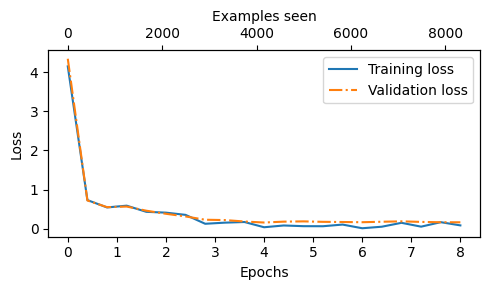

In [125]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

we can see that there is almost no difference between training and validation losses => there is no overfitting

In [126]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.79%
Validation accuracy: 97.22%
Test accuracy: 97.64%


### Using LLM as a Spam Classifier

Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

In [127]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    
    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [128]:
text_1 = (
    "Hello , Tejas can you please send me the report by EOD? "
    "I need it for the meeting tomorrow. "
    "Thank you!"
)

text_2 = (
    "Congratulations! You've won a $1000 cash prize! "
    "Click here to claim it."
    "You are a winner you have been specially selected to receive this offer."
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam
spam


In [129]:
# torch.save(model.state_dict(), "spam_classifier.pth")


In [130]:
model_state_dict = torch.load("spam_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Insctruction Based Finetuning

Build a Personal Assistant from scratch 

In instruction Fine-Tuning , input-output pairs are explicitly specified ; Hence it is also called supervised instruction finetuning 

### Preparing Dataset

* Each Data has instruction , input and output 

In [131]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


In [132]:
print(data[1000])

{'instruction': 'Name three forms of water.', 'input': '', 'output': 'The three forms of water are solid (ice), liquid (water), and gas (steam).'}


There are 2 types of formatting our instructions (Prompt) : Alpaca and Phi-3 

 We will be following **Stanford Alpaca** for instructions :

 ---

 Below is an instruction that describes a task. Write a response that appropriately completes the request.

**Instruction:**
Identify the correct spelling of the following word.

**Input:**
Ocassion

**Response:**
The correct spelling is 'Occasion'.

In [133]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f" Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}\n\n"
        )
    input_text = f"\n\n### Input:\n{entry['input']}\n\n" if entry['input'] else ""

    return instruction_text + input_text 

In [134]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.



### Input:
Ocassion



### Response:
The correct spelling is 'Occasion.'


this will be the prompt for the fine-tuning 

### Splitting data into Train-Test-Val

In [135]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]


print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Data Batching 

In [136]:
from torch.utils.data import Dataset

class InstructionDataset(Dataset):

    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in self.data:
            instruction_plus_input = format_input(entry)
            response_tecxt = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_tecxt
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)




Padding and creating input token IDs function 

In [137]:
def custom_collate_draft_1(batch,pad_token_id=50256,device='cpu'):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below

    batch_max_length = max(len(seq) + 1 for seq in batch)

    inputs_list = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id] 
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))

        inputs = torch.tensor(padded[:-1])
        inputs_list.append(inputs)
    
    inputs_tensor = torch.stack(inputs_list).to(device)

    return inputs_tensor
    


In [138]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Creating Target Token IDs


In [139]:
def custom_collate_draft_2(batch, pad_token_id=50256, device='cpu'):
    # Find the longest sequence in the batch
    batch_max_length = max(len(seq)+1 for seq in batch)

    inputs_list , targets_list = [],[]

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]  # Add an extra padding token
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])  # Exclude the last token for inputs
        targets = torch.tensor(padded[1:])  # Exclude the first token for targets

        inputs_list.append(inputs)
        targets_list.append(targets)

    # Stack the inputs and targets tensors
    
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)

    return inputs_tensor , targets_tensor

In [140]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_2(batch))

(tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]]), tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]]))


In the next step, we assign a -100 placeholder value to all padding tokens. (barring one 50256 token at the end of every sentence because that is necessary.)

This special value allows us to exclude these padding tokens from contributing to
the training loss calculation, ensuring that only meaningful data influences model learning.



In [141]:
def custom_collate_function(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=1024,
    device= "mps" if torch.backends.mps.is_available() else "cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [142]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inp , outp = custom_collate_function(batch)
print("Inputs Tensor:\n", inp)
print("Targets Tensor:\n", outp)


Inputs Tensor:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='mps:0')
Targets Tensor:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]], device='mps:0')


Pytorch ignores index -100 while calculating cross-entropy loss .

That is why we implement padding with -100 token so that it doesnt affect the loss

### Masking Target Token IDS

In addition to masking out padding tokens, it is also common to mask out the target
token IDs that correspond to the instruction

By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the generated response target

### Creating DataLoaders

In [143]:
num_workers = 0
batch_size = 8

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_function,
    num_workers=num_workers,
    drop_last=True
)
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_function,
    num_workers=num_workers,
    drop_last=True
)
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_function,
    num_workers=num_workers,
    drop_last=True
)
print('Train Loader:')
for inputs , targets in train_loader:
    print(inputs.shape, targets.shape)


Train Loader:
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 93]) torch.Size([8, 93])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 61]) torch.

### Loading Pretrained LLM

We wil use the 124M parameter GPT-2 model which we have donwloaded before

In [144]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "dropout": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Users/tejas/venv-metal/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


Performance before Finetuning 

In [145]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'




In [146]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [147]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active sentence


### Fine-Tuning on Instruction data 

We will reuse the functions : calc_loss_batch( ), calc_loss_loader( ) , train_model_simple( ) from pre-training step 

In [148]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [149]:
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device,num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)


print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
    


Training loss: 4.380
Validation loss: 4.263


In [150]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=10, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.340, Val loss 3.283
Ep 1 (Step 000010): Train loss 1.312, Val loss 1.186
Ep 1 (Step 000020): Train loss 0.929, Val loss 1.043
Ep 1 (Step 000030): Train loss 0.897, Val loss 0.959
Ep 1 (Step 000040): Train loss 0.819, Val loss 0.920
Ep 1 (Step 000050): Train loss 0.777, Val loss 0.898
Ep 1 (Step 000060): Train loss 0.811, Val loss 0.868
Ep 1 (Step 000070): Train loss 0.744, Val loss 0.849
Ep 1 (Step 000080): Train loss 0.729, Val loss 0.832
Ep 1 (Step 000090): Train loss 0.635, Val loss 0.810
Ep 1 (Step 000100): Train loss 0.714, Val loss 0.790
Ep 1 (Step 000110): Train loss 0.759, Val loss 0.784
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'    ### Response: The chef cooks the meal every day.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately complete

since we are using only 124M parameter pretrained  GPT model - the results are not that great. 

If we use larger models the results will improve 

In [151]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

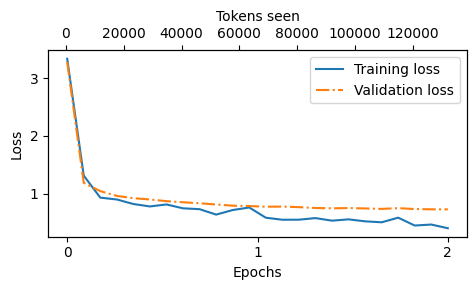

In [152]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Saving responses 

Step 1: Iterate over the first 3 test set samples

Step 2:  Use the generate function defined earlier

In [153]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.



### Input:
The car is very fast.



Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?



Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud typically associated with thunderstorms is the active component of the active component of the active component of the active component of the active component of the active component of the active component of the active component of the active component of the active component of the active component of the active component of the 

### Evaluating the LLM response 

In practice, instruction-finetuned LLMs
such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple choice benchmarks such as MMLU ("Measuring
Massive Multitask Language Understanding," https://arxiv.org/abs/2009.03300), which test the general knowledge of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot
arena (https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval (https://tatsulab.github.io/alpaca_eval/).
completes the request.

In [154]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:44<00:00,  1.05it/s]


To prepare the responses for this evaluation process, we append the generated model
responses to the test_set dictionary and save the updated data as an "instructiondata-with-response.json" file for record keeping. 

Additionally, by saving this file, we can
easily load and analyze the responses in separate Python sessions later on if needed.

In [155]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a horse.'}


In [156]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-small124M-sft.pth"))

Model saved as gpt2-small124M-sft.pth


### Evaluating the Fine-Tuned LLM


To implement the evaluation step which involves evaluating test set responses in
an automated fashion, we utilize an existing instruction-finetuned 8 billion parameter Llama
3 model developed by Meta AI. 

This model can be run locally using the open-source Ollama
application (https://ollama.com).

In [157]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [158]:
import urllib.request

def query_model(
    prompt,
    model="llama3.2",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [159]:
model = "llama3.2"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and vitamins.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach, which allows them to break down and extract nutrients from plant material more efficiently than many other 

Using the query_model function defined earlier, we can evaluate the responses generated
by our finetuned model with a prompt that prompts the Llama 3 model to rate our
finetuned model's responses on a scale from 0 to 100 based on the given test set response
as reference.

In [160]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.

Score:
>> To rewrite the sentence using a simile, we need to compare the speed of the car to something else.

Correct output:
The car is as fast as lightning.

Score: 100

Explanation: The model response "The car is as fast as a horse" is incorrect because it uses a metaphor (comparing two things that are not alike) instead of a simile (comparing two things using "like" or "as"). A simile explicitly states the comparison, whereas a metaphor equates one thing with another. In this case, the correct response should use "as fast as" to make the comparison explicit.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud typically associated with thunderstorms is the active component of the active component of the active component of the active component of the active component of t

Based on the generated responses, we can observe that the Llama 3 model provides
reasonable evaluations and is capable of assigning partial points when a model's answer is
not entirely correct. 

for entry in test_data[:2]:
    prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
    score = query_model(prompt, model)
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, model))
    print("\n-------------------------")

In [161]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

To further improve our model's performance, we can explore various strategies, such as:

(1) Adjusting the hyperparameters during finetuning, such as the learning
rate, batch size, or number of epochs.


(2) Increasing the size of the training dataset or diversifying the examples to
cover a broader range of topics and styles.


(3) Experimenting with different prompts or instruction formats to guide the
model's responses more effectively.


(4) Considering the use of a larger pretrained model, which may have greater
capacity to capture complex patterns and generate more accurate
responses.

(5) We can also use parameter efficient fine-tuning techniques like LoRA.